In [1]:
#@title
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Séries Temporais (Time Series)

Notebook de apoio para a **Aula 002: Time Series (Séries Temporais) - Parte 2**

## Técnicas de *Forecasting* para Séries Temporais

O universo das Séries Temporais (TS) é gigante e complexo. Existem muitos métodos e maneiras de se realizar previsões em cima de bases históricas. Não é minha intenção apresentar extensivamente todas elas, mas sim fomentar a sua vontade por meio de conhecimentos basilares de *Time Series*.

A primeira coisa que vai ter que estar na sua cabeça é que **quanto maior o seu horizonte de previsão, maior a incerteza associada a ele, ou seja, maior o erro**.

Quanto mais no futuro você tentar ver algo, menor será sua capacidade de inferir algo. Bem-vindo ao mundo real.

Para ajudar nessa tarefa, existem desde técnicas simples (qual será o valor da sua conta de celular no próximo mês) e metodologias altamente complexas e com conceitos estatísticos mais pesados (qual o risco de um tornado atingir aquela cidade).

Vamos dar uma olhada nos principais modelos básicos. Usaremos novamente a base de dados da produção de energia elétrica da última aula.

In [2]:
# importar pacotes e setar configurações de plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

sns.set_style()

%config InlineBackend.figure_format = 'svg'

In [3]:
# url do dataset
dataset_path = "https://raw.githubusercontent.com/inaepmachado/DataSet/master/Electric_Production.csv"

# importar o csv para um dataframe
df = pd.read_csv(dataset_path)
# identifica o tipo da data e transforma em datetime
df.DATE = pd.to_datetime(df.DATE, format="%m-%d-%Y")
# coloca a própria 'DATE' como index dos dados
df.set_index('DATE', inplace=True)

# ver as 5 primeiras entradas
df.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### 1. Naive Approach

No "Modelo Ingênuo", a previsão de $P_{T+1}$ é apenas uma mera observação do período imediatamente anterior ($P_T$), ou seja, a previsão do $P_{T+1}$ é exatamente igual ao $P_T$. Pense, qual seria o melhor chute para você dizer quanto viria a conta de celular no próximo mês?!

<br>
<center>
<img src="https://miro.medium.com/max/974/1*aVBE9ixa9HEV4Zd3keZE4A.png" width="400px">
</center>

Partir da premissa que "o futuro repetirá o passado", mesmo que parece algo ingênuo, serve como um *benchmark*, um *baseline* inicial. E por que isso?

Imagine que você construa um modelo com todas as técnicas mais avançadas, treina redes neurais profundas em cima de GPUs da AWS por dias... para descobrir que ele foi pior que um modelo Naive?

In [4]:
# identifica qual a menor e a maior data existente nos dados
print("Data mínima: ", df.index.min())
print("Data máxima: ", df.index.max())


Data mínima:  1985-01-01 00:00:00
Data máxima:  2018-01-01 00:00:00


In [5]:
# dividir entre treino e validação arbitrariamente considerando o intervalo abaixo
train = df[df.index <= '2012-8-1']
valid = df[df.index > '2012-8-1']

# criar um dataframe para armazenar as previsões
y_hat = valid.copy()

y_hat.index.min()

Timestamp('2012-09-01 00:00:00')

Exclusivamente por causa da didática, vou dividir o conjunto de dados em dois.

Vou utilizar períodos amplos para que a aplicação dos métodos seja perceptível visualmente.

In [6]:
# identifica o último valor atribuído ao dia 2012-08-01: estamos acessando o último valor através do INDEX
train.iloc[-1].values[0]

109.8601

In [7]:
# copiar o último valor do dataset train e atribuir à h_hat['naive'] - o último valor será o baseline
y_hat['naive'] = train.iloc[-1].values[0]

y_hat['naive']

DATE
2012-09-01    109.8601
2012-10-01    109.8601
2012-11-01    109.8601
2012-12-01    109.8601
2013-01-01    109.8601
                ...   
2017-09-01    109.8601
2017-10-01    109.8601
2017-11-01    109.8601
2017-12-01    109.8601
2018-01-01    109.8601
Name: naive, Length: 65, dtype: float64

In [8]:
y_hat.head()

,Value,naive
DATE,,
2012-09-01,96.7431,109.8601
2012-10-01,90.3805,109.8601
2012-11-01,94.3417,109.8601
2012-12-01,105.2722,109.8601
2013-01-01,115.5010,109.8601


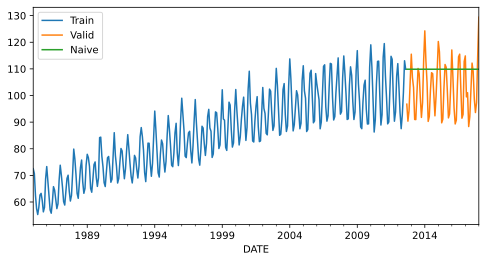

In [9]:
# plotar train e valid
fig, ax = plt.subplots(figsize=(8,4))
train.plot(ax=ax)
valid.plot(ax=ax)
y_hat['naive'].plot(ax=ax)
ax.legend(['Train', 'Valid', 'Naive'])
plt.show()

In [10]:
# Calcular o erro da previsão RMSE, comparando a curva verde (baseline) com a laranja
print("Erro Naive Method:")
mean_squared_error(y_hat.Value, y_hat.naive, squared=True)

Erro Naive Method:


144.1829082647693

### 2. Média Móvel

Se no Método *Naive* nós consideramos apenas o último valor disponível, as médias móveis permitem utilizarmos uma janela de intervalo.

Se você investe na Bolsa como trader, provavelmente já usou médias móveis com valores de 7, 14 e 21 dias. 

Médias móveis são excelentes para suavizar curvas (e diminuir a dispersão/ruído) ou mesmo para criar novas variáveis (*feature engineering*).

Voltando ao exemplo da sua conta de celular, usando média móvel nós poderíamos usar (por exemplo) as 7 últimas faturas e prever as demais.

In [11]:
# calcular a média dos últimos 7 valores disponíveis
y_hat['m7'] = train.Value.rolling(7).mean().iloc[-1]

print("Valor da média móvel dos últimos 7 valores: \n", train.Value.rolling(7).mean().iloc[-1])

y_hat.head()

Valor da média móvel dos últimos 7 valores: 
 100.18539999999985


,Value,naive,m7
DATE,,,
2012-09-01,96.7431,109.8601,100.1854
2012-10-01,90.3805,109.8601,100.1854
2012-11-01,94.3417,109.8601,100.1854
2012-12-01,105.2722,109.8601,100.1854
2013-01-01,115.5010,109.8601,100.1854


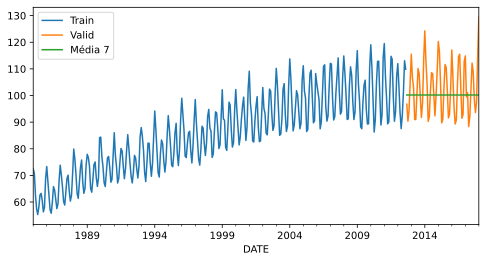

In [12]:
# plotar train e valid
fig, ax = plt.subplots(figsize=(8,4))
train.plot(ax=ax)
valid.plot(ax=ax)
y_hat['m7'].plot(ax=ax)
ax.legend(['Train', 'Valid', 'Média 7'])
plt.show();

In [13]:
# Calcular o erro da previsão RMSE
print("Erro da Média de 7 dias:")
mean_squared_error(y_hat.Value, y_hat.m7, squared=True)

Erro da Média de 7 dias:


101.2125496049239

### 3. Holt's Linear Trend Model

Qual o problema das técnicas acima? Elas não permitem que trabalhemos com **tendências** (apenas o nível das séries).

Já o *Holt's Linear Trend Model* leva em consideração tanto o nível quanto a tendência, e tende a obter melhores resultados que as técnicas mencionadas anteriormente.

###Vamos separar os componentes da Série Temporal

In [14]:
# importar pacotes necessários
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


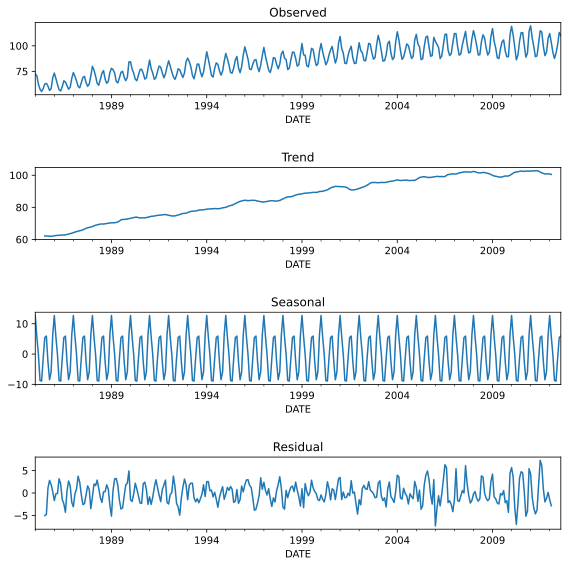

In [15]:
# salvar os componentes da *time series* na variável results da base de treino
result = seasonal_decompose(train)

# plotar componentes
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(8,8))
ax1.set_title("Observed")
result.observed.plot(ax=ax1, legend=False)
ax2.set_title("\nTrend")
result.trend.plot(ax=ax2, legend=False)
ax3.set_title("\nSeasonal")
result.seasonal.plot(ax=ax3, legend=False)
ax4.set_title("\nResidual")
result.resid.plot(ax=ax4, legend=False)
plt.tight_layout()

Essa decomposição da série pode ser feita de duas maneiras:

1) Modelo aditivo: a série é a soma dos três componentes Tendência, Sazonalidade e Resíduo.

2) Modelo multiplicativo: a série é a multiplicação dos três componentes Tendência, Sazonalidade e Resíduo.

Existem alguns testes para identificar se a série possui **TENDÊNCIA** ou não. Porém, estes testes em geral se baseiam em hipóteses que podem não estar verificadas no caso de uma série temporal, por exemplo, supor que as observações são independentes. É necessário estar atento se existe outra componente na série, como sazonalidade, além de tendência e precisamos eliminar esta componente antes de testar a tendência, pois há uma grande influência de outras componentes sobre a tendência. Os testes que podem ser aplicados são:  Teste de Wald - Wolfowitz, Teste de Cox-Stuart e Teste de Mann-Kendall. Um procedimento que é normalmente utilizado para remover tendências é tomar sucessivas diferenças da série original até encontrar uma série estacionária.

Dizemos que uma série temporal é **SAZONAL** quando os fenômenos que ocorrem durante o tempo se repete a cada período idêntico de tempo, ou seja, fenômenos que ocorrem diariamente em uma certa hora, todos os dias, ou em um certo mês em todos os anos. Existem dois tipos de sazonalidade: **Determinística**, quando pressupomos um padrão sazonal regular e estável no tempo, desta forma podemos prever o comportamento sazonal perfeitamente a partir de dados anteriores; **Estocástica**, quando a componente sazonal da série varia com o tempo. Podemos utilizar métodos paramétricos e não paramétricos para determinar sazonalidade determinísticas e, para qualquer teste, é necessário eliminar a tendência da série se ela existir: Teste de Kruskal-Wallis, Teste de Friedman, Teste F.


*Referência: Análise de séries temporais(2006) / Pedro A. Morettin, Célia M. C. Toloi.*

In [16]:
# salvar os valores para o dataset valid usando Holt's 
# parâmetros escolhidos de forma arbitrária: smoothing_level escolhe a altura do Holt; smoothing_slope escolhe a inclinação do Holt
# a escolha dos parâmetros deve ser com a que se encaixa melhor, quanto maior esse valor, maior fica o descolamento da curva com o real nesse caso
y_hat['holt'] = Holt(train.Value).fit(smoothing_level = 0.1,
                                      smoothing_slope=0.1).forecast(len(valid))

y_hat['holt']

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


DATE
2012-09-01    101.997350
2012-10-01    102.029656
2012-11-01    102.061963
2012-12-01    102.094269
2013-01-01    102.126576
                 ...    
2017-09-01    103.935741
2017-10-01    103.968047
2017-11-01    104.000354
2017-12-01    104.032660
2018-01-01    104.064967
Name: holt, Length: 65, dtype: float64

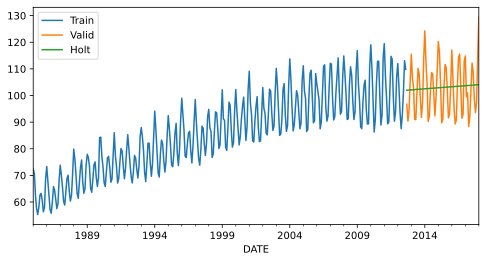

In [17]:
# plotar train e valid
fig, ax = plt.subplots(figsize=(8,4))
train.plot(ax=ax)
valid.plot(ax=ax)
y_hat['holt'].plot(ax=ax)
ax.legend(['Train', 'Valid', 'Holt'])
plt.show()

In [18]:
# Calcular o erro
print("Erro do Holt's Linear Trend Model:")
mean_squared_error(valid.Value, y_hat.holt, squared=True)

Erro do Holt's Linear Trend Model:


93.79197449495115

## Séries Estacionárias

Antes de se pensar em fazer previsões e modelagens preditivas, você tem que ter um conceito bem fixado: séries estacionárias.

Uma TS é chamada de estacionária caso possua suas propriedades estatísticas sejam **constantes** em relação ao tempo. Por exemplo, são critérios básicos:

1. Média constante em relação ao tempo.
2. Variância constante em relação ao tempo.
3. Covariância entre os termos $T_i$ e $T_{i+m}$ é constante em relação ao tempo (relação entre as variáveis constante).

E por que isso? Porque a grande maioria dos métodos estatísticos assumem essa premissa.

**E caso minha TS não seja estacionária?**

Bom, nesse caso você terá que aplicar transformações matemáticas para que ela se torne estacionária, obrigatoriamente.

**E o exemplo de produção de energia elétrica? É estacionário ou não?**

Apenas olhando o gráfico original e os componentes separados, já conseguimos notar que existe no mínimo uma tendência de crescimento. No entanto, "olhômetro" não é um método muito científico. Então, como devemos proceder?

Devemos utilizar testes estatísticos para confirmar se uma série é estacionária ou não. Vamos utilizar aqui o ***ADF (Augmented Dickey-Fuller) Test***, ou Teste de Dickey-Fuller Aumentado.

### Teste de Dickey-Fuller

Resumidamente, o ADF tem a capacidade de nos dizer se uma TS é estacionária ou não. Sem entrarmos (ainda) em detalhes, vamos rodar o teste estatístico e ver o que ele nos fala.

In [19]:
# importar o teste ADF
from statsmodels.tsa.stattools import adfuller

# importar os dados como sendo coluna única
df_est = pd.read_csv(dataset_path, index_col=0, squeeze=True)

# preciso extrair apenas os valores, não precisamos da série completa com a data
X = df_est.values

X

array([ 72.5052,  70.672 ,  62.4502,  57.4714,  55.3151,  58.0904,
        62.6202,  63.2485,  60.5846,  56.3154,  58.0005,  68.7145,
        73.3057,  67.9869,  62.2221,  57.0329,  55.8137,  59.9005,
        65.7655,  64.4816,  61.0005,  57.5322,  59.3417,  68.1354,
        73.8152,  70.062 ,  65.61  ,  60.1586,  58.8734,  63.8918,
        68.8694,  70.0669,  64.1151,  60.3789,  62.4643,  70.5777,
        79.8703,  76.1622,  70.2928,  63.2384,  61.4065,  67.1097,
        72.9816,  75.7655,  67.5152,  63.2832,  65.1078,  73.8631,
        77.9188,  76.6822,  73.3523,  65.1081,  63.6892,  68.4722,
        74.0301,  75.0448,  69.3053,  65.8735,  69.0706,  84.1949,
        84.3598,  77.1726,  73.1964,  67.2781,  65.8218,  71.4654,
        76.614 ,  77.1052,  73.061 ,  67.4365,  68.5665,  77.6839,
        86.0214,  77.5573,  73.365 ,  67.15  ,  68.8162,  74.8448,
        80.0928,  79.1606,  73.5743,  68.7538,  72.5166,  79.4894,
        85.2855,  80.1643,  74.5275,  69.6441,  67.1784,  71.2

In [20]:
# aplicar ADF e imprimir o resultado
result = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('Valor-p: {:.4f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -2.2570
Valor-p: 0.1862
Valores Críticos:
	1%: -3.4476
	5%: -2.8692
	10%: -2.5708


Vamos entender um pouco sobre o que está sendo verificado.

* A Hipótese Nula ($H_0$) do teste é que a TS não é estacionária. Ou seja, possui algum tipo de dependência em relação ao tempo.
* A Hipótese Alternativa ($H_1$) rejeita a hipótese nula, ou seja, que a TS é estacionária.

Interpretamos o resultado do teste usando o *valor-p* com um *threshold* que traga indícios suficientes para rejeitarmos a hipótese nula. Caso o valor do teste fique acima desse *threshold*, falharemos em rejeitar a hipótese nula e manteremos a premissa de que ela não é estacionária.

Os valores do *threshold* que irei usar são:

* $\text{Valor-p } \leq 0.05$: Rejeitamos $H_0$ e a TS é estacionária; e
* $\text{Valor-p } > 0.05$: Não rejeitamos $H_0$ e a TS é não-estacionária.
